In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("WorldFoodProductionPipeline") \
    .master("local[*]") \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")


25/11/17 18:46:06 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [5]:
# Update with your file path
df = spark.read.csv("/Users/hemandh/Study Materials/Sem-1/Cloud/world food production.csv", header=True, inferSchema=True)
df.printSchema()
df.show(5)

root
 |-- Entity: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Maize Production (tonnes): double (nullable = true)
 |-- Rice  Production ( tonnes): double (nullable = true)
 |-- Yams  Production (tonnes): double (nullable = true)
 |-- Wheat Production (tonnes): double (nullable = true)
 |-- Tomatoes Production (tonnes): double (nullable = true)
 |-- Tea  Production ( tonnes ): double (nullable = true)
 |-- Sweet potatoes  Production (tonnes): double (nullable = true)
 |-- Sunflower seed  Production (tonnes): double (nullable = true)
 |-- Sugar cane Production (tonnes): double (nullable = true)
 |-- Soybeans  Production (tonnes): double (nullable = true)
 |-- Rye  Production (tonnes): double (nullable = true)
 |-- Potatoes  Production (tonnes): double (nullable = true)
 |-- Oranges  Production (tonnes): double (nullable = true)
 |-- Peas, dry Production ( tonnes): double (nullable = true)
 |-- Palm oil  Production (tonnes): double (nullable = true)
 |-- Grapes  Pro

In [6]:
import re
from pyspark.sql.functions import col, trim

# Clean column names
cleaned = df
for c in cleaned.columns:
    new = re.sub(r'[^A-Za-z0-9_ ]+', '', c.strip())      # remove special chars
    new = new.replace(" ", "_")                          # spaces → underscores
    cleaned = cleaned.withColumnRenamed(c, new)

cleaned.printSchema()

root
 |-- Entity: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Maize_Production_tonnes: double (nullable = true)
 |-- Rice__Production__tonnes: double (nullable = true)
 |-- Yams__Production_tonnes: double (nullable = true)
 |-- Wheat_Production_tonnes: double (nullable = true)
 |-- Tomatoes_Production_tonnes: double (nullable = true)
 |-- Tea__Production__tonnes_: double (nullable = true)
 |-- Sweet_potatoes__Production_tonnes: double (nullable = true)
 |-- Sunflower_seed__Production_tonnes: double (nullable = true)
 |-- Sugar_cane_Production_tonnes: double (nullable = true)
 |-- Soybeans__Production_tonnes: double (nullable = true)
 |-- Rye__Production_tonnes: double (nullable = true)
 |-- Potatoes__Production_tonnes: double (nullable = true)
 |-- Oranges__Production_tonnes: double (nullable = true)
 |-- Peas_dry_Production__tonnes: double (nullable = true)
 |-- Palm_oil__Production_tonnes: double (nullable = true)
 |-- Grapes__Production_tonnes: double (nullabl

In [7]:
from pyspark.sql.functions import expr

cols = cleaned.columns
entity_col = "Entity" if "Entity" in cols else "Country"
year_col = "Year"

item_cols = [c for c in cols if c not in (entity_col, year_col)]

# build stack() expression
stack_expr = "stack({}, {}) as (Item, Value)".format(
    len(item_cols),
    ", ".join([f"'{c}', `{c}`" for c in item_cols])
)

long_df = cleaned.select(
    col(entity_col).alias("Country"),
    col(year_col).alias("Year"),
    expr(stack_expr)
)

long_df.show(10)

+-----------+----+--------------------+---------+
|    Country|Year|                Item|    Value|
+-----------+----+--------------------+---------+
|Afghanistan|1961|Maize_Production_...| 700000.0|
|Afghanistan|1961|Rice__Production_...| 319000.0|
|Afghanistan|1961|Yams__Production_...|7467702.0|
|Afghanistan|1961|Wheat_Production_...|2279000.0|
|Afghanistan|1961|Tomatoes_Producti...|1873812.0|
|Afghanistan|1961|Tea__Production__...|  56315.0|
|Afghanistan|1961|Sweet_potatoes__P...|3270871.0|
|Afghanistan|1961|Sunflower_seed__P...|  12000.0|
|Afghanistan|1961|Sugar_cane_Produc...|  45000.0|
|Afghanistan|1961|Soybeans__Product...|  71813.0|
+-----------+----+--------------------+---------+
only showing top 10 rows


25/11/17 18:46:53 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [8]:
from pyspark.sql.functions import regexp_replace

df_clean = long_df.withColumn("Item", regexp_replace(col("Item"), "_", " ")) \
                 .withColumn("Year", col("Year").cast("int")) \
                 .withColumn("Value", col("Value").cast("double")) \
                 .dropna(subset=["Country", "Item", "Year", "Value"]) \
                 .filter(col("Value") > 0)

df_clean.show(10)

+-----------+----+--------------------+---------+
|    Country|Year|                Item|    Value|
+-----------+----+--------------------+---------+
|Afghanistan|1961|Maize Production ...| 700000.0|
|Afghanistan|1961|Rice  Production ...| 319000.0|
|Afghanistan|1961|Yams  Production ...|7467702.0|
|Afghanistan|1961|Wheat Production ...|2279000.0|
|Afghanistan|1961|Tomatoes Producti...|1873812.0|
|Afghanistan|1961|Tea  Production  ...|  56315.0|
|Afghanistan|1961|Sweet potatoes  P...|3270871.0|
|Afghanistan|1961|Sunflower seed  P...|  12000.0|
|Afghanistan|1961|Sugar cane Produc...|  45000.0|
|Afghanistan|1961|Soybeans  Product...|  71813.0|
+-----------+----+--------------------+---------+
only showing top 10 rows


In [10]:
from pyspark.sql.functions import expr, min, max, col, when

stats = df_clean.groupBy("Item").agg(
    expr("percentile_approx(Value, 0.25) as Q1"),
    expr("percentile_approx(Value, 0.75) as Q3"),
    min("Value").alias("MinV"),
    max("Value").alias("MaxV")
)

joined = df_clean.join(stats, on="Item", how="left") \
    .withColumn("IQR", col("Q3") - col("Q1")) \
    .withColumn("Upper_Bound", col("Q3") + 3 * col("IQR")) \
    .withColumn("Lower_Bound", col("Q1") - 3 * col("IQR")) \
    .withColumn("Is_Outlier", 
                (col("Value") > col("Upper_Bound")) | 
                (col("Value") < col("Lower_Bound"))) \
    .withColumn(
        "Value_Cleaned",
        when(col("Is_Outlier"), None).otherwise(col("Value"))
    )

joined.show(10)

+--------------------+-----------+----+---------+--------+-----------+----+-----------+------------------+------------------+--------------------+----------+-------------+
|                Item|    Country|Year|    Value|      Q1|         Q3|MinV|       MaxV|               IQR|       Upper_Bound|         Lower_Bound|Is_Outlier|Value_Cleaned|
+--------------------+-----------+----+---------+--------+-----------+----+-----------+------------------+------------------+--------------------+----------+-------------+
|Maize Production ...|Afghanistan|1961| 700000.0| 27000.0|  5121820.0| 1.0|1.2102351E9|         5094820.0|        2.040628E7|         -1.525746E7|     false|     700000.0|
|Rice  Production ...|Afghanistan|1961| 319000.0| 48908.0|4843963.684|0.03| 7.872939E8|       4795055.684|    1.9229130736E7|-1.43362590520000...|     false|     319000.0|
|Yams  Production ...|Afghanistan|1961|7467702.0|12225.35|   573192.8|3.54| 7.871405E7| 560967.4500000001|2256095.1500000004|          -1670

In [11]:
from pyspark.sql.window import Window
from pyspark.sql.functions import lag, lead

w = Window.partitionBy("Country", "Item").orderBy("Year")

interp = joined \
    .withColumn("Prev_Year", lag("Year").over(w)) \
    .withColumn("Prev_Value", lag("Value_Cleaned").over(w)) \
    .withColumn("Next_Year", lead("Year").over(w)) \
    .withColumn("Next_Value", lead("Value_Cleaned").over(w))

interp2 = interp.withColumn(
    "Value_Final",
    when(
        (col("Value_Cleaned").isNull()) &
        (col("Prev_Value").isNotNull()) &
        (col("Next_Value").isNotNull()) &
        ((col("Next_Year") - col("Prev_Year")) == 2),
        (col("Prev_Value") + col("Next_Value")) / 2
    ).otherwise(col("Value_Cleaned"))
)

df_final = interp2.select("Country","Year","Item","Value_Final","Is_Outlier") \
                  .withColumnRenamed("Value_Final","Value")

df_final.show(10)

+-----------+----+--------------------+-----+----------+
|    Country|Year|                Item|Value|Is_Outlier|
+-----------+----+--------------------+-----+----------+
|Afghanistan|1961|Cocoa beans Produ...| NULL|      true|
|Afghanistan|1962|Cocoa beans Produ...| NULL|      true|
|Afghanistan|1963|Cocoa beans Produ...| NULL|      true|
|Afghanistan|1964|Cocoa beans Produ...| NULL|      true|
|Afghanistan|1965|Cocoa beans Produ...| NULL|      true|
|Afghanistan|1966|Cocoa beans Produ...| NULL|      true|
|Afghanistan|1967|Cocoa beans Produ...| NULL|      true|
|Afghanistan|1968|Cocoa beans Produ...| NULL|      true|
|Afghanistan|1969|Cocoa beans Produ...| NULL|      true|
|Afghanistan|1970|Cocoa beans Produ...| NULL|      true|
+-----------+----+--------------------+-----+----------+
only showing top 10 rows


In [12]:
from pyspark.sql.functions import sum as _sum

country_year = df_final.groupBy("Country", "Year") \
    .agg(_sum("Value").alias("Total_Production"))

country_year.show(10)

+-------------------+----+----------------+
|            Country|Year|Total_Production|
+-------------------+----+----------------+
|     Americas (FAO)|2012|   1.443665988E7|
|             Angola|1979|   2.376257673E7|
|             Angola|1987|    2.54721833E7|
|Antigua and Barbuda|1995|    1.81633387E7|
|Antigua and Barbuda|2017|   3.148901943E7|
|          Argentina|2010|      1.437947E7|
|         Azerbaijan|2012|      1641259.35|
|            Bahamas|1968|      1054702.83|
|         Bangladesh|1987|   1.256936031E7|
|           Barbados|2019|       4737089.0|
+-------------------+----+----------------+
only showing top 10 rows


In [17]:
from pyspark.sql.window import Window
from pyspark.sql.functions import lag, col, round

w2 = Window.partitionBy("Country").orderBy("Year")

growth_df = country_year.withColumn(
    "Prev_Production", lag("Total_Production").over(w2)
).withColumn(
    "Growth_Rate",
    round(((col("Total_Production") - col("Prev_Production")) 
           / col("Prev_Production")) * 100, 2)
)

growth_df.show(10)

+-----------+----+----------------+---------------+-----------+
|    Country|Year|Total_Production|Prev_Production|Growth_Rate|
+-----------+----+----------------+---------------+-----------+
|Afghanistan|1961|      1.119131E7|           NULL|       NULL|
|Afghanistan|1962|     1.0544126E7|     1.119131E7|      -5.78|
|Afghanistan|1963|     1.0438442E7|    1.0544126E7|       -1.0|
|Afghanistan|1964|     1.1230422E7|    1.0438442E7|       7.59|
|Afghanistan|1965|     1.1548018E7|    1.1230422E7|       2.83|
|Afghanistan|1966|      1.158245E7|    1.1548018E7|        0.3|
|Afghanistan|1967|     1.1899207E7|     1.158245E7|       2.73|
|Afghanistan|1968|      1.243367E7|    1.1899207E7|       4.49|
|Afghanistan|1969|     1.2984368E7|     1.243367E7|       4.43|
|Afghanistan|1970|     1.2607801E7|    1.2984368E7|       -2.9|
+-----------+----+----------------+---------------+-----------+
only showing top 10 rows


In [18]:
from pyspark.sql.functions import rank, desc

rank_window = Window.partitionBy("Year").orderBy(desc("Total_Production"))

top5 = country_year.withColumn("Rank", rank().over(rank_window)) \
                   .filter(col("Rank") <= 5)

top5.show(20)

+--------------------+----+--------------------+----+
|             Country|Year|    Total_Production|Rank|
+--------------------+----+--------------------+----+
|               China|1961|      1.2363261864E8|   1|
|              Brazil|1961|1.1286613969999999E8|   2|
|                USSR|1961|1.1237988219999999E8|   3|
|             Burundi|1961|        9.72145338E7|   4|
|        Burkina Faso|1961|       9.311997054E7|   5|
|              Brazil|1962|      1.1431118668E8|   1|
|             Burundi|1962|       1.083530722E8|   2|
|             Somalia|1962|1.0372533254599999E8|   3|
|        Burkina Faso|1962|      1.0336669039E8|   4|
|                USSR|1962|1.0278841008600001E8|   5|
|              Brazil|1963|      1.2053113615E8|   1|
|             Somalia|1963|     1.04565443592E8|   2|
|Western Africa (FAO)|1963| 8.763910942800002E7|   3|
|             Uruguay|1963|      8.3970013678E7|   4|
|              Africa|1963|       7.795139872E7|   5|
|              Brazil|1964| 

In [19]:
item_rank = df_final.groupBy("Item") \
    .agg(_sum("Value").alias("Total_Production")) \
    .orderBy(desc("Total_Production"))

item_rank.show(10)

+--------------------+--------------------+
|                Item|    Total_Production|
+--------------------+--------------------+
|Sugar cane Produc...|1.223676192603281...|
|Wheat Production ...|7.141454674075394E10|
|Maize Production ...|1.900560702226999...|
|Rice  Production ...| 1.78302523025628E10|
|Grapes  Productio...|1.724592507718902E10|
|Potatoes  Product...|1.485587877870899...|
|Apples Production...| 9.904846898254974E9|
|Oranges  Producti...| 8.102938212270023E9|
|Sunflower seed  P...| 5.907034932376015E9|
|Bananas  Producti...| 5.230868889919007E9|
+--------------------+--------------------+
only showing top 10 rows


In [20]:
growth_df.write.mode("overwrite").csv("/Users/hemandh/Study Materials/Sem-1/Cloud/country_year_growth", header=True)
top5.write.mode("overwrite").csv("/Users/hemandh/Study Materials/Sem-1/Cloud/top5_countries", header=True)
df_final.write.mode("overwrite").csv("/Users/hemandh/Study Materials/Sem-1/Cloud/cleaned_long", header=True)
item_rank.write.mode("overwrite").csv("/Users/hemandh/Study Materials/Sem-1/Cloud/item_totals", header=True)


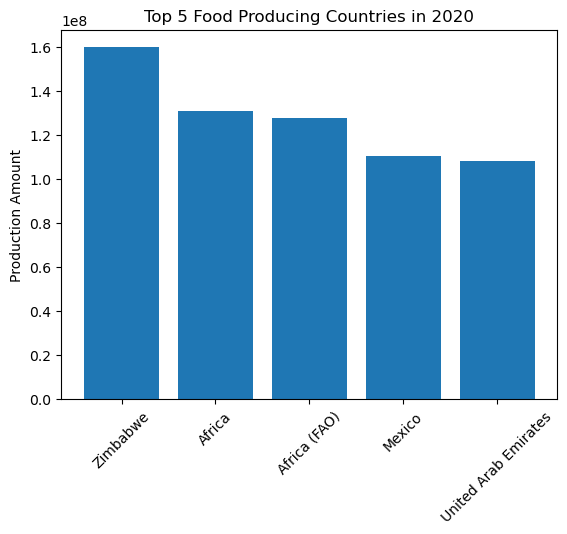

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

pdf = country_year.toPandas()

top5_2020 = pdf[pdf["Year"] == 2020]\
             .sort_values("Total_Production", ascending=False)\
             .head(5)

plt.bar(top5_2020["Country"], top5_2020["Total_Production"])
plt.xticks(rotation=45)
plt.title("Top 5 Food Producing Countries in 2020")
plt.ylabel("Production Amount")
plt.show()